# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding (Problem Statement)

In this case, we want to explore the effectiveness of Starbucks offers. To achieve the goal, we will split the exploration into a few steps:
### 1. Understand what offers do Starbucks have and Starbucks customer background
- 1.1. What kind of offers does Starbucks provide? What characteristics does each offer type have?
- 1.2. What are the demographic characteristics of members?
- 1.3. How different do people react to the different promotion offers(transaction characteristics)?

### 2. Explore the offer effectiveness
- 2.1. How many offers did we send to customers?
- 2.2. Which type of offer is more attractive to customers?
- 2.3. How long do people respond to an offer?
- 2.4. How many offers are wasted?
- 2.5. What kind of people are more likely to waste an offer?
- 2.6. Build a prediction engine to determine if customer will waste an offer or not

# Data Understanding -- EDA

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, fbeta_score, recall_score,confusion_matrix, classification_report \
,roc_auc_score, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## portfolio dataset

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

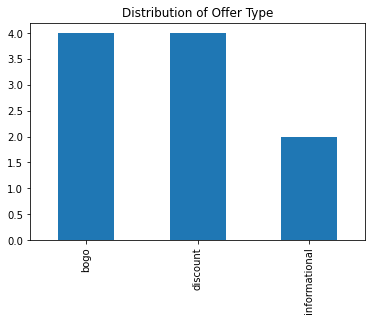

In [7]:
# Count offers by offer type
portfolio['offer_type'].value_counts().plot.bar(title='Distribution of Offer Type', color='tab:blue');

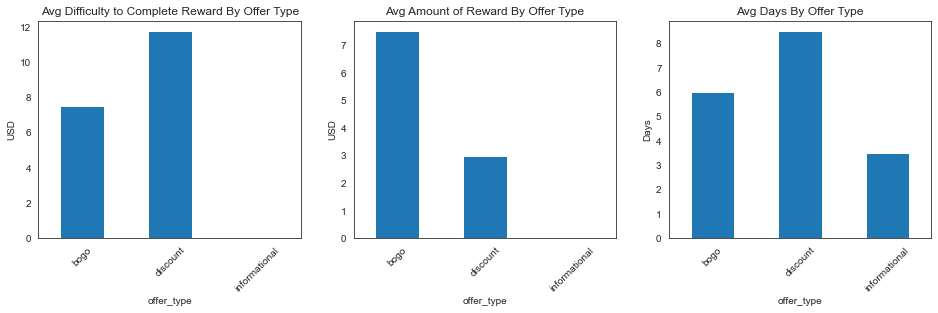

In [8]:
# Explore by offer type

plt.figure(figsize=[16,4])
#sns.set_palette("muted")
base_color = sns.color_palette()[0]
sns.set_style("white")

plt.subplot(1,3,1)
portfolio.groupby('offer_type')['difficulty'].mean().plot(kind='bar', color=base_color)
plt.title('Avg Difficulty to Complete Reward By Offer Type')
plt.ylabel('USD')
plt.xticks(rotation=45);

plt.subplot(1,3,2)
portfolio.groupby('offer_type')['reward'].mean().plot(kind='bar', color=base_color)
plt.title('Avg Amount of Reward By Offer Type')
plt.ylabel('USD')
plt.xticks(rotation=45);

plt.subplot(1,3,3)
portfolio.groupby('offer_type')['duration'].mean().plot(kind='bar', color=base_color)
plt.title('Avg Days By Offer Type')
plt.ylabel('Days')
plt.xticks(rotation=45);

### portfolio dataset EDA Insight

- 10 rows, 6 columns in total
- no missing value and duplicates
- the content of channel column may need to split into columns(4 channels)

## profile dataset

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [13]:
# check duplicates

profile.id.duplicated().sum()

0

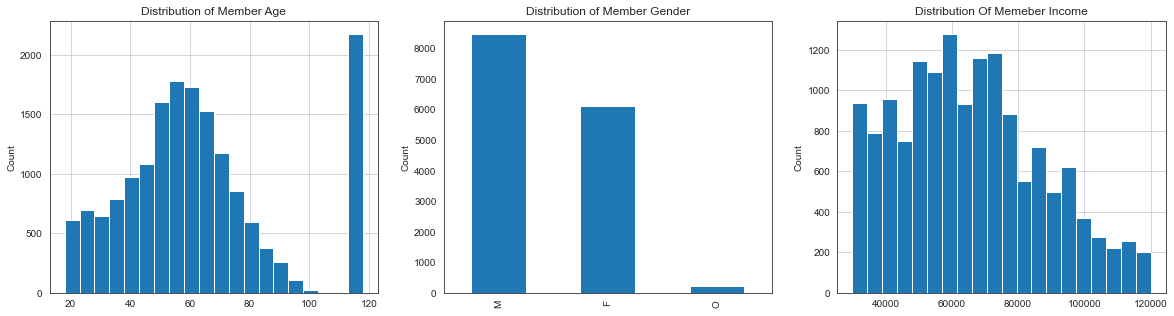

In [14]:
# Explore member distribution

plt.figure(figsize=[20,5])
color = sns.color_palette()[0]
sns.set_style("white")
sns.set_palette("muted")

plt.subplot(1,3,1)
profile['age'].hist(bins=20, color=base_color)
plt.title('Distribution of Member Age')
plt.ylabel('Count');

plt.subplot(1,3,2)
profile['gender'].value_counts().plot(kind='bar', color=base_color)
plt.title('Distribution of Member Gender')
plt.ylabel('Count');

plt.subplot(1,3,3)
profile['income'].hist(bins=20, color=base_color)
plt.title('Distribution Of Memeber Income')
plt.ylabel('Count');

In [15]:
# Check outliers in age

print('The amount of missing values in gender column: {}'.format(profile.gender.isnull().sum()))
print('The amount of missing values in income column: {}'.format(profile.income.isnull().sum()))
print('The number of outliers age in 118: {}'.format(profile[profile.age == 118]['id'].count()))

profile_missing_data = profile[(profile.age == 118) & (profile.gender.isnull()) & (profile.income.isnull())]
print('The number of records which has age in 118 and missing value in both gender and income columns'\
    .format(len(profile_missing_data)))
print('Missing value percentage in the dataset: {:.2f}'.format(len(profile_missing_data) / profile.shape[0]))
profile_missing_data.sample(3)


The amount of missing values in gender column: 2175
The amount of missing values in income column: 2175
The number of outliers age in 118: 2175
The number of records which has age in 118 and missing value in both gender and income columns
Missing value percentage in the dataset: 0.13


,gender,age,id,became_member_on,income
2384,None,118,c69c472adbaa425aa5cfd727f4978ea1,20170606,NaN
8116,None,118,cc9cc688903c431e8fa18db43ea4cb3b,20171017,NaN
14485,None,118,f33f934662044f889318b4e5410da827,20171205,NaN


In [16]:
# drop missing value rows

print('{} records BEFORE drop missing values'.format(profile.shape))
profile = profile.dropna(how='any')
print('{} records AFTER drop missing values'.format(profile.shape))
profile.isnull().sum()

(17000, 5) records BEFORE drop missing values
(14825, 5) records AFTER drop missing values


gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [17]:
# Assign customers to groups based on age and income

def assign_age_group(df=profile):
    '''
    INPUT:
    df - a dataframe contains age column
    
    OUTPUT:
    df - a dataframe convert age to age_group column
    '''
    df.loc[(df.age < 20) , 'age_group'] = '<20'
    df.loc[(df.age >= 20) & (df.age <= 29) , 'age_group'] = '20-29'
    df.loc[(df.age >= 30) & (df.age <= 39) , 'age_group'] = '30-39'
    df.loc[(df.age >= 40) & (df.age <= 49) , 'age_group'] = '40-49'
    df.loc[(df.age >= 50) & (df.age <= 59) , 'age_group'] = '50-59'
    df.loc[(df.age >= 60) & (df.age <= 69) , 'age_group'] = '60-69'
    df.loc[(df.age >= 70) , 'age_group'] = '>=70'
    #df.drop('age',axis=1,inplace=True)
    
    return df

def assign_income_group(df=profile):
    '''
    INPUT:
    df - a dataframe contains income column
    
    OUTPUT:
    df - a dataframe convert income to income_group column
    '''
    df.loc[(df.income < 50000) , 'income_group'] = '<50k'
    df.loc[(df.income >= 50000) & (df.income < 80000) , 'income_group'] = '50k-80k'
    df.loc[(df.income >= 80000) & (df.income < 100000) , 'income_group'] = '80k-100k'
    df.loc[(df.income >= 100000), 'income_group'] = '>=100k'
    #df.drop('income',axis=1,inplace=True)
    
    return df

profile = assign_age_group(profile)
profile = assign_income_group(profile)

In [18]:
#  deal with date in became_member_on column

def clean_became_member_on(df=profile):
    '''
    INPUT:
    df - a dataframe contains became_member_on column
    
    OUTPUT:
    df - a dataframe convert became_member_on column to datetime type and add a new column named membership_in_years to
         to record membership duration in years.
    '''
    #  convert became_member_on to datetime data tpe
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

    # Add a new column membership_in_years to calculate the duration since became a member
    df['membership_in_years'] = datetime.datetime.today().date() - df['became_member_on'].dt.date
    df['membership_in_years'] = round(df['membership_in_years'].dt.days / 365, 1)
    
    # Add a new column member_since to record the year when became a member
    df['member_since'] = df['became_member_on'].dt.year
    
    return df

profile = clean_became_member_on(profile)
    

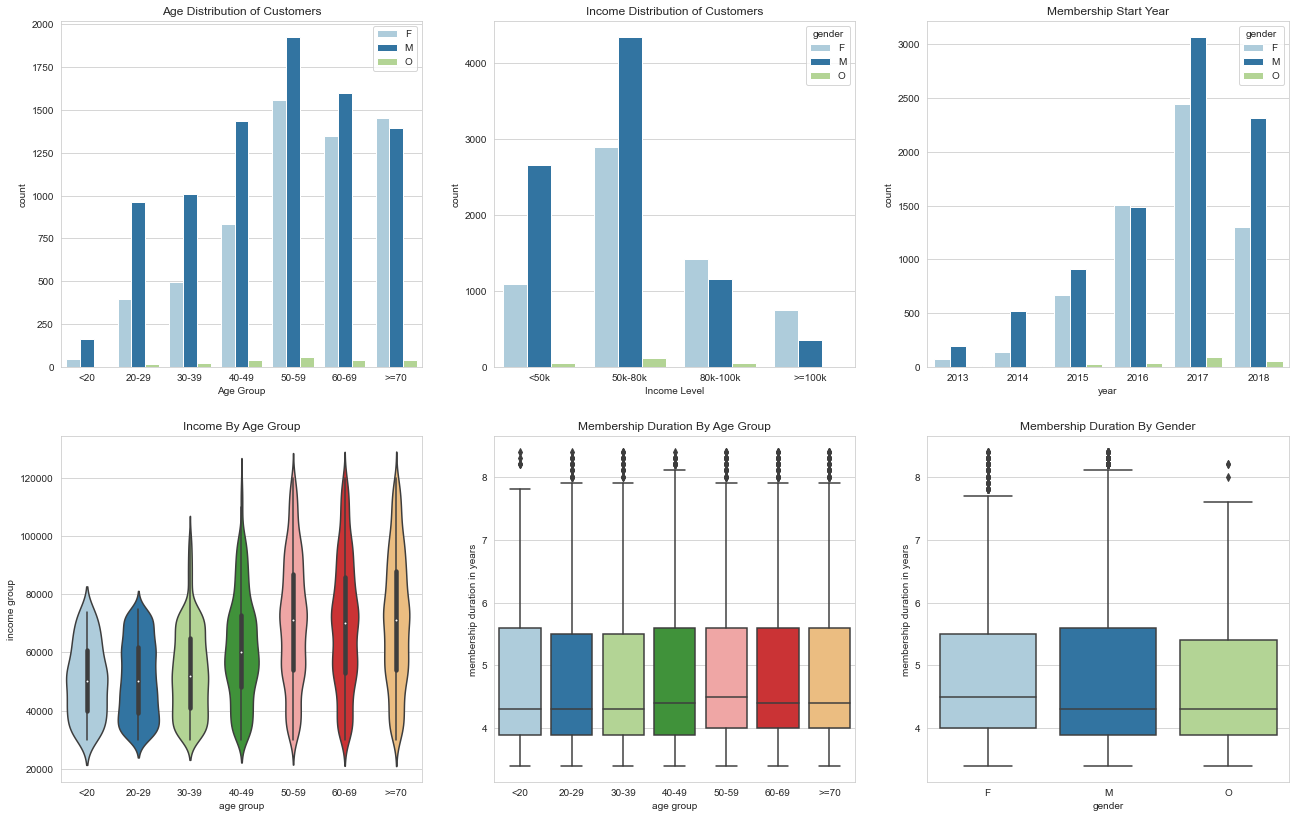

In [19]:
# Visualize data by age_groups, income_group, year after cleaned Profile data

plt.figure(figsize = [22,14])
age_order = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '>=70']
income_order = ['<50k', '50k-80k', '80k-100k', '>=100k']
gender_order = ['F', 'M', 'O']

sns.set_style("whitegrid")
sns.set_palette("Paired")
plt.subplot(2,3,1)
sns.countplot(data = profile, x = 'age_group', hue = 'gender', order = age_order)
plt.legend(loc='upper right')
plt.title('Age Distribution of Customers')
plt.ylabel('count')
plt.xlabel('Age Group');

plt.subplot(2,3,2)
sns.countplot(data = profile, x = 'income_group', hue = 'gender', order = income_order)
plt.title('Income Distribution of Customers')
plt.ylabel('count')
plt.xlabel('Income Level');

plt.subplot(2,3,3)
sns.countplot(data = profile, x = 'member_since', hue = 'gender')
plt.title('Membership Start Year')
plt.ylabel('count')
plt.xlabel('year');

plt.subplot(2,3,4)
sns.violinplot(data = profile, x = 'age_group', y = 'income', order = age_order)
plt.title('Income By Age Group')
plt.ylabel('income group')
plt.xlabel('age group');

plt.subplot(2,3,5)
sns.boxplot(data = profile, x = 'age_group', y = 'membership_in_years', order = age_order)
plt.title('Membership Duration By Age Group')
plt.ylabel('membership duration in years')
plt.xlabel('age group');

plt.subplot(2,3,6)
sns.boxplot(data = profile, x = 'gender', y = 'membership_in_years')
plt.title('Membership Duration By Gender')
plt.ylabel('membership duration in years')
plt.xlabel('gender');


In [20]:
profile.sample(5)

,gender,age,id,became_member_on,income,age_group,income_group,membership_in_years,member_since
2248,M,43,6c9b18ecc7054a3fa2e56d793a09f46b,2016-09-25,40000.0,40-49,<50k,5.2,2016
13232,M,55,d11b5f234e114b00a1bb71f5865367fb,2016-09-26,73000.0,50-59,50k-80k,5.2,2016
8735,M,49,d2e43709c6114a7f99289d92bf9666b1,2015-10-06,37000.0,40-49,<50k,6.2,2015
2428,F,56,cd26c24371e7403ababb09120b0654b1,2016-02-07,79000.0,50-59,50k-80k,5.8,2016
1231,M,65,d80211f9f5ff46408d55adee3727aff3,2016-03-23,31000.0,60-69,<50k,5.7,2016


In [21]:
profile.id.nunique()

14825

### profile dataset EDA Insight
- 17000 rows and 5 columns in total
- 2175 missing values in the id and income column (removed)
- No duplicated id, means no duplicated customer record
- Become_memeber_on column needs to convert to datetime type and add a new column: membership_in_years for membership duration calculated in years(done)
- age column contains outliers(age=118), which seems not true in reality (removed)
- Add a new column: age_group column to categorize customer based on age (done)
- Add a new column: income_group column to categorize customer based on income (done)

## transcript dataset

In [22]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [25]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [26]:
print('The number of unique customer id in transcript: {}'.format(transcript.person.nunique()))
print('The number of unique customer id in profile: {}'.format(profile.id.nunique()))
print('The numer of ids in both transcript and profile datasets: {}'\
      .format(len(set(transcript.person.unique()).intersection(set(profile.id.unique())))))

The number of unique customer id in transcript: 17000
The number of unique customer id in profile: 14825
The numer of ids in both transcript and profile datasets: 14825


In [27]:
# Check keys in value column

value_keys = transcript['value'].apply(lambda x: x.keys())
print(value_keys.value_counts())

(amount)              138953
(offer id)            134002
(offer_id, reward)     33579
Name: value, dtype: int64


In [28]:
def clean_value_col(df=transcript):
    '''
    INPUT:
    df - a dataframe contains value column
    
    OUTPUT:
    df - a dataframe with new columns: offer_id, reward, spent separated from value column
    '''
    # Extract key-values from value column and create new columns
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id') if x.get('offer id')==None else x.get('offer id'))
    df['spent'] = df['value'].apply(lambda x: x.get('amount'))
    df['gained'] = df['value'].apply(lambda x: x.get('reward'))
    
    # Drop 'value' column 
    df.drop('value', axis=1, inplace=True)
    
    # Replace NANs
    df.fillna(value={'spent':0, 'gained':0} , inplace=True)
    
    return df

transcript = clean_value_col()

# alternative approch
#transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [29]:
# Check duplicates
# A record with same person, offer_id, time, event is treated as a duplicate

print('The number of duplicates: {}'.format(transcript[transcript.duplicated(subset=['person','offer_id','time', 'event'])].shape[0]))

# Look into duplicates 
print("duplicate records by event status:",transcript[transcript.duplicated(subset=['person','offer_id', 'event','time'])].sort_values(by=['person','time'])['event'].value_counts())

# View duplicates
transcript[transcript.duplicated(subset=['person','offer_id', 'event','time'])].sort_values(by=['person','time']).head()


The number of duplicates: 397
duplicate records by event status: offer completed    397
Name: event, dtype: int64


,person,event,time,offer_id,spent,gained
218060,00d7c95f793a4212af44e632fdc1e431,offer completed,504,2906b810c7d4411798c6938adc9daaa5,0.0,2.0
220134,01925607d99c460996c281f17cdbb9e2,offer completed,510,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0
171647,01956670cf414b309675aa73368b94a9,offer completed,420,2906b810c7d4411798c6938adc9daaa5,0.0,2.0
184897,01ff6c5d8d014dbd8c120e2b43a065ea,offer completed,444,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0
186624,0200f61c69da4c2ea078842cdaf234e6,offer completed,450,2906b810c7d4411798c6938adc9daaa5,0.0,2.0


In [30]:
# Remove duplicates
transcript = transcript.drop_duplicates(subset=['person','offer_id','event','time'])
transcript.shape

(306137, 6)

In [31]:
transcript.sample(5)

,person,event,time,offer_id,spent,gained
273531,23277625ebb9416582f62f328a6a5a8b,transaction,600,None,1.09,0.0
116204,87576d8c2371491f9d6127f2235bfdfe,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0
296259,397363559b35488cb7f52f79b055a331,transaction,666,None,8.17,0.0
119510,06d34b0fb66e4feea9b2c765755a8e1f,offer received,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0
293349,d95023d1b9384f11861dcde35e65ce8c,transaction,660,None,4.41,0.0


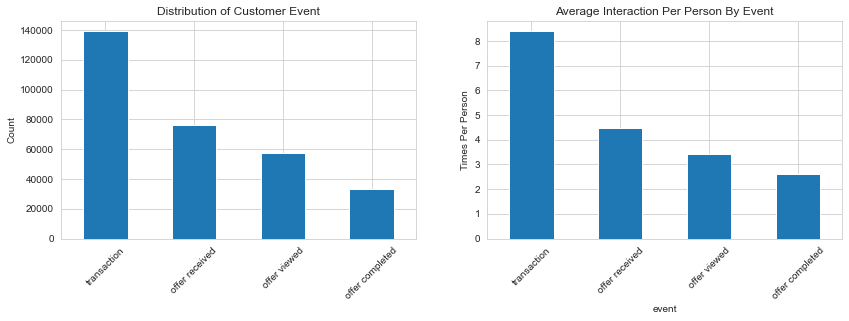

In [32]:
plt.figure(figsize=[14,4])
sns.set_style("whitegrid")

plt.subplot(1,2,1)
transcript.event.value_counts().plot(kind='bar', color=base_color)
plt.title('Distribution of Customer Event')
plt.ylabel('Count')
plt.xticks(rotation=45);

plt.subplot(1,2,2)
transcript.groupby(['person','event']).size().unstack().mean().sort_values(ascending=False).plot(kind='bar', color=base_color)
plt.title('Average Interaction Per Person By Event')
plt.ylabel('Times Per Person')
plt.xticks(rotation=45);


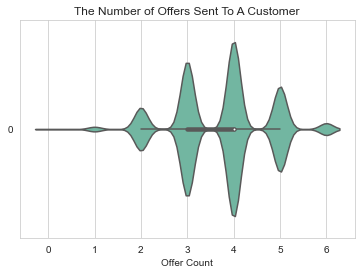

In [33]:
offer_ctn_per_person = transcript.groupby(['person'])['offer_id'].nunique()
sns.violinplot(data=offer_ctn_per_person,showmeans=True,orient='h', palette='Set2')
plt.title('The Number of Offers Sent To A Customer')
plt.xlabel('Offer Count');

### transcript dataset EDA Insight

- 306534 rows and 4 columns in the original dataset, no missing values
- 14825 out of 17000 customer ids from transcript dataset exist in profile dataset. 
- value column needs to split into several columns for each key-value pair in the series(done)
- There are 397 duplicates regarding to the same pereson, offer_id, tiem, event. All the duplicates are cased by the duplicated event status 'offer completed'. (removed)
- The value column containing very important values are split into three columns: offer_id, spent, gained.
- There are 4 types of event from the most number of records to the least are: transaction, offer received, offer veiwed, offer completed.

### Combine Dataset -- starbucks

Combine three datasets together into a new dataframe(starbucks) for integrated analysis. portfolio dataset shares offer_id with transcript dataset. transcript dataset shares customer_id with profile dataset. 

In [34]:
# Combine three datasets together

# merge transtript and portfolio
portfolio = portfolio.rename(columns={'id': 'offer_id'})
starbucks = pd.merge(transcript, portfolio, on='offer_id', how='left')

# merge with profile
profile = profile.rename(columns={'id': 'person'})
starbucks = pd.merge(starbucks, profile, on='person', how='left')

print(starbucks.shape)
starbucks.info()

(306137, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               306137 non-null  object        
 1   event                306137 non-null  object        
 2   time                 306137 non-null  int64         
 3   offer_id             167184 non-null  object        
 4   spent                306137 non-null  float64       
 5   gained               306137 non-null  float64       
 6   reward               167184 non-null  float64       
 7   channels             167184 non-null  object        
 8   difficulty           167184 non-null  float64       
 9   duration             167184 non-null  float64       
 10  offer_type           167184 non-null  object        
 11  gender               272388 non-null  object        
 12  age                  272388 non-null  float64       
 13  b

In [35]:
# Check missing value percentage in merged dataset starbucks

starbucks.isnull().sum() / starbucks.shape[0]

person                 0.000000
event                  0.000000
time                   0.000000
offer_id               0.453892
spent                  0.000000
gained                 0.000000
reward                 0.453892
channels               0.453892
difficulty             0.453892
duration               0.453892
offer_type             0.453892
gender                 0.110241
age                    0.110241
became_member_on       0.110241
income                 0.110241
age_group              0.110241
income_group           0.110241
membership_in_years    0.110241
member_since           0.110241
dtype: float64

In [36]:
print('The number of duplicates: {}'.format(transcript[transcript.duplicated(subset=['person','offer_id','time', 'event'])].shape[0]))

The number of duplicates: 0


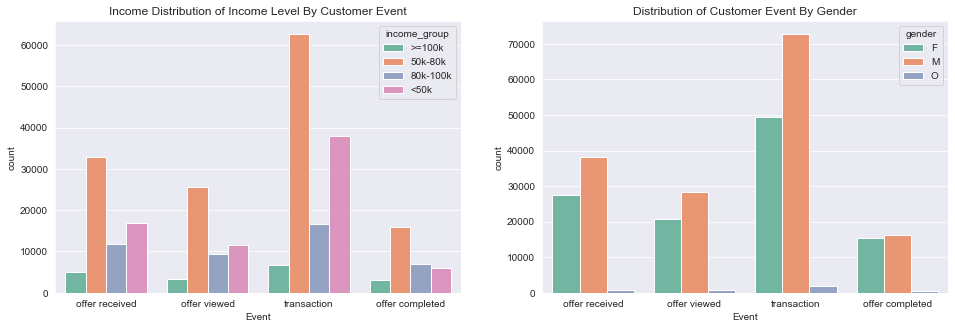

In [86]:
# Visualize combined data

plt.figure(figsize = [16,5])

sns.set_style("darkgrid")
sns.set_palette("Set2")

plt.subplot(1,2,1)
sns.countplot(data = starbucks, x = 'event', hue = 'income_group')
plt.title('Income Distribution of Income Level By Customer Event')
plt.ylabel('count')
plt.xlabel('Event');

plt.subplot(1,2,2)
sns.countplot(data = starbucks, x = 'event', hue = 'gender')
plt.title('Distribution of Customer Event By Gender')
plt.ylabel('count')
plt.xlabel('Event');

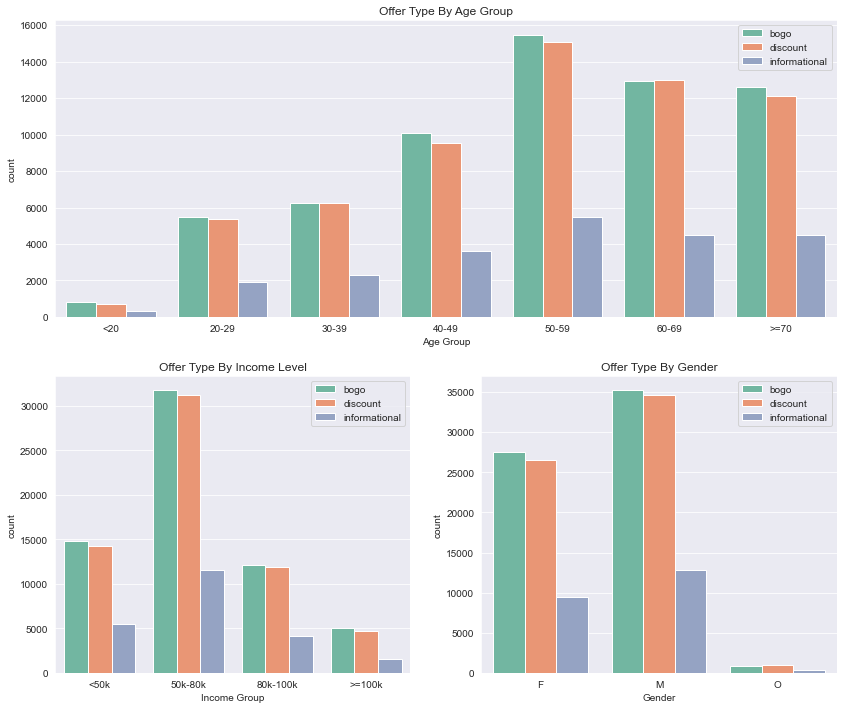

In [38]:
plt.figure(figsize=[14, 12])

plt.subplot(2,1,1)
sns.countplot(data = starbucks, x = 'age_group', hue = 'offer_type', order = age_order)
plt.legend(loc='upper right')
plt.title('Offer Type By Age Group')
plt.ylabel('count')
plt.xlabel('Age Group');

plt.subplot(2,2,3)
sns.countplot(data = starbucks, x = 'income_group', hue = 'offer_type', order = income_order)
plt.legend(loc='upper right')
plt.title('Offer Type By Income Level')
plt.ylabel('count')
plt.xlabel('Income Group');

plt.subplot(2,2,4)
sns.countplot(data = starbucks, x = 'gender', hue = 'offer_type')
plt.legend(loc='upper right')
plt.title('Offer Type By Gender')
plt.ylabel('count')
plt.xlabel('Gender');

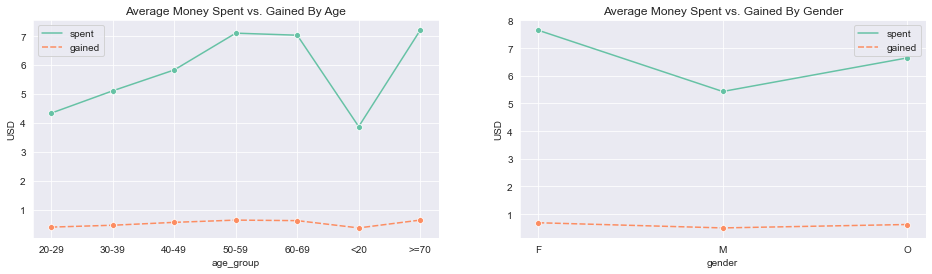

In [39]:
# Explore money spent vs. gained

plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
spent_by_age = starbucks.dropna(subset=['age_group']).groupby('age_group').spent.mean()
gained_by_age = starbucks.dropna(subset=['age_group']).groupby('age_group').gained.mean()
money_age_group = pd.concat([spent_by_age, gained_by_age], axis=1)
sns.lineplot(data = money_age_group, marker = 'o')
plt.title('Average Money Spent vs. Gained By Age')
plt.ylabel('USD');

plt.subplot(1,2,2)
spent_by_gender = starbucks.dropna(subset=['gender']).groupby('gender').spent.mean()
gained_by_gender = starbucks.dropna(subset=['gender']).groupby('gender').gained.mean()
money_gender = pd.concat([spent_by_gender, gained_by_gender], axis=1)
sns.lineplot(data = money_gender, marker = 'o')
plt.title('Average Money Spent vs. Gained By Gender')
plt.ylabel('USD');


## EDA Insight

#### Q1. What kind of offers does Starbucks provide? What characristics does each offer type have? 
  - There are three types of offers: BOGO, discount and informational offer.
  - There are more BOGO and discount offers than informational offer.
  - Informational offer doesn't require to spend money and no reward as a result, and it lasts shortest time about 3 days.
  - BOGO is the best promotion offer to customers - cost less than discount to get more reward. It is ususally available for about 6 days, which is shorter than discount offers. 
  
#### Q2. What are the demographic characteristics of members?
  - Gender: There are more male than female members
  - Age: most members are between the ages of 21-70, especially a large group of those are between 50-60. Only a small part of members are under 20. The number of males and females at the age of 20s and 30s are quite close.
  - Income: It seems people whose annual income is between 50k-80k are more likely to become a Starbucks member. While there are many more male members than females who make less than 80k a year, we see there are more female members in the same income level above 80k a year. The income distribution of members under 40 is almost the same, compared to the older members.
  - Membership: There is no obvious difference in average membership duration among age groups. Female members have greater membership duration on average. As the number of members grows year over year, it is always more male members than female members, except in the year 2016. We see there are a little bit more females joining Starbucks membership.
  
  
#### Q3. How differently do people react to the different promotion offers(transaction characteristics)?
 - Most people received 2-5 offers in the experiment and with an average of 4 offers.
 - BOGO and Discount types are sent to a similar amount of customers. It turns out that more people completed discount type offers than BOGO type, while BOGO offers are viewed by more people than discount offers.
 - There is less percentage of people from 30-39 age group to complete offers.
 - Males spent much less money than females, but still gained similar rewards.
 - Discount type offer takes the longest for customers to make a reaction.

# Data Preparation

A lot of data cleaning and data wrangling has been done in the previous Data Understanding section. At the end of EDA, we have combined three datasets together into a new dataframe(starbucks) for integrated analysis. In the Data Preparation part, we will focus on collecting all useful information to explore the offer effectiveness and prepare input data for modeling. We will take advantage of the several sub-tasks to explore the offer effectiveness:
  - How many offers did we send to customers?
  - Which type of offer is more attractive to customers?
  - How long do people respond to an offer?
  - How many offers are wasted?
  - What kind of people are more likely to waste an offer?
  - Build a prediction engine to determine if the customer will waste an offer or not

To prepare appropriate input data for modeling, We will need to process data feather by handling duplicates and missing values, renaming column names, feature selection, label encoding, etc.

## Explore Offer Effectiveness

From the above data understanding, we know that there are four types of events: offer completed, offer received, offer viewed, and transaction; three types of offer: BOGO, Discount, Informational.

Among the three types of offers, BOGO and Discount offer to require customers to spend a certain amount of money in order to achieve the reward. So there's an offer_id tied with the transaction to record the usage of the offer. Informational offer that no need to spend money and no reward will be generated. To sum up, if we want to know the effectiveness of the offer, we need to determine if an offer is wasted or not. The approaches of how offers will be converted are different, shown as below:

  - **BOGO** and **Discount** offer: offer received -> offer viewed -> offer completed(offer effective). Note: if an offer is used without viewing, it should be treated as not effective since the customer didn't notice the offer.

  - **Informational** offer: offer received -> offer viewed(offer effective)

### Q1. How many offers did Starubucks send to customers?

Total number of offers sent to customers: 167184


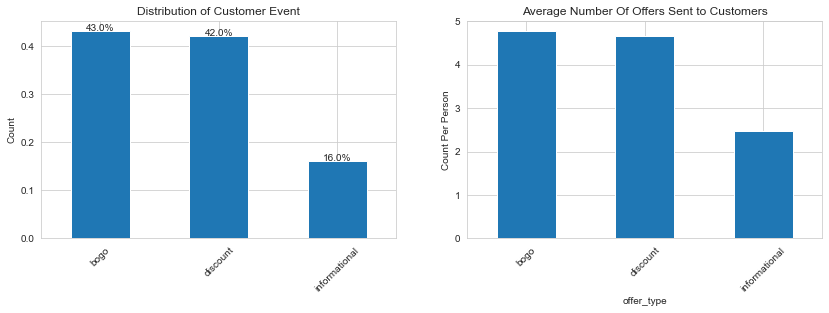

In [83]:
print('Total number of offers sent to customers: {}'.format(starbucks.offer_id.count()))

plt.figure(figsize=[14,4])
sns.set_style("whitegrid")

plt.subplot(1,2,1)
ax = starbucks.offer_type.value_counts(normalize=True).round(2).plot(kind='bar', color=base_color)
plt.title('Distribution of Customer Event')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate('{}%'.format(p.get_height()* 100, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   xytext=(0, 3),  # 3 points vertical offset
                   ha = 'center', va = 'center', 
                   textcoords = 'offset points');

plt.subplot(1,2,2)
starbucks.groupby(['person','offer_type']).size().unstack().mean().sort_values(ascending=False).plot(kind='bar', color=base_color)
plt.title('Average Number Of Offers Sent to Customers')
plt.ylabel('Count Per Person')
plt.xticks(rotation=45);

- There are 167184 offers sent to customer, around 43% is BOGO type, 42% is Discount type and 16% is Informational type.
- On average, customer received more than 4 BOGO and Discount offers and around 2.5 Informational offer.

### Q2. Which type of offer is more attractive to customers?

viewed/recieved, completed/viewed (% for three types)  OR wasted vs. not %

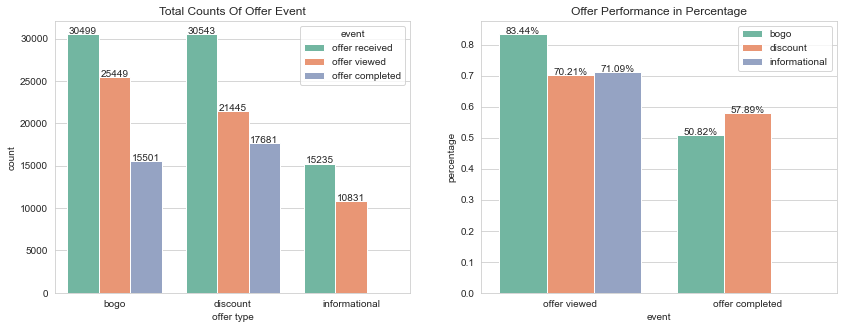

In [43]:
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
offer_performance = starbucks[starbucks['event'] != 'transaction']
ax = sns.countplot(data=offer_performance, x='offer_type', hue='event')
plt.title('Total Counts Of Offer Event')
plt.xlabel('offer type')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   xytext=(0, 3),  # 3 points vertical offset
                   ha = 'center', va = 'center', 
                   textcoords = 'offset points');

offer_type_received = offer_performance[offer_performance['event'] == 'offer received']['offer_type'].value_counts().to_dict()
offer_event = offer_performance.groupby(['offer_type','event'])['offer_id'].count().reset_index()
offer_event['received'] = offer_event['offer_type'].map(offer_type_received)
offer_event['percentage'] = round(offer_event['offer_id'] / offer_event['received'], 4)
viewed_received = offer_event[offer_event['event'] == 'offer viewed'][['offer_type','percentage']]
completed_received = offer_event[offer_event['event'] == 'offer completed'][['offer_type','percentage']]
offer_perf = offer_event[offer_event['event']!='offer received']

plt.subplot(1,2,2)
ax = sns.barplot(data=offer_perf, x='event', y='percentage', hue='offer_type', 
            order=['offer viewed', 'offer completed'])
plt.legend(loc='upper right')
plt.title('Offer Performance in Percentage');
for p in ax.patches:
    ax.annotate('{}%'.format(p.get_height()* 100, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   xytext=(0, 3),  # 3 points vertical offset
                   ha = 'center', va = 'center', 
                   textcoords = 'offset points')

- Among 30499 received BOGO offers, 83.44% offer are viewed by people which is the most viewed offer type, but only 50.82% BOGO offer are used.
- Among 30543 received Discount offers, 70.21% are viewed, about 12% lower than BOGO type, but higher percentage of offers are used.
- 71.09% Information offer are viewed by customer.

### Q3. How long do people respond to an offer?

/var/folders/bd/_8dghbl54l9gjwr9n4klhv9c0000gn/T/ipykernel_9368/1325342868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_performance['days'] = offer_performance['time'].apply(lambda x: int(x / 24.0) + (x % 24 > 0))


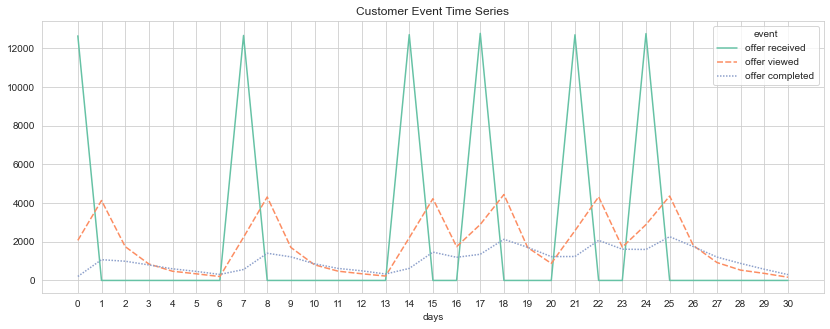

In [44]:
# change the time in hours to days, rounding up
offer_performance['days'] = offer_performance['time'].apply(lambda x: int(x / 24.0) + (x % 24 > 0))
person_offer_time = offer_performance.groupby(['person', 'days','offer_type', 'event']).size().unstack(fill_value=0).reset_index()
offer_time = person_offer_time.groupby('days').sum()
offer_time = offer_time[['offer received', 'offer viewed', 'offer completed']]

plt.figure(figsize=[14,5])
sns.lineplot(data = offer_time).set_xticks(offer_time.index)
plt.title('Customer Event Time Series');

- There are 6 waves of offer events in this experiment. Usually offers are viewed one day after customer received the offer. The trend of offer comleted is similar to that of offer viewed. 

### Q4. How many offers are wasted?

In [45]:
starbucks = starbucks.join(pd.get_dummies(starbucks[['event']]))
starbucks = starbucks.rename(columns={'event_offer completed':'event_offer_completed', 
                                      'event_offer received':'event_offer_received',
                                      'event_offer viewed':'event_offer_viewed'})
starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   person                 306137 non-null  object        
 1   event                  306137 non-null  object        
 2   time                   306137 non-null  int64         
 3   offer_id               167184 non-null  object        
 4   spent                  306137 non-null  float64       
 5   gained                 306137 non-null  float64       
 6   reward                 167184 non-null  float64       
 7   channels               167184 non-null  object        
 8   difficulty             167184 non-null  float64       
 9   duration               167184 non-null  float64       
 10  offer_type             167184 non-null  object        
 11  gender                 272388 non-null  object        
 12  age                    272388 non-null  floa

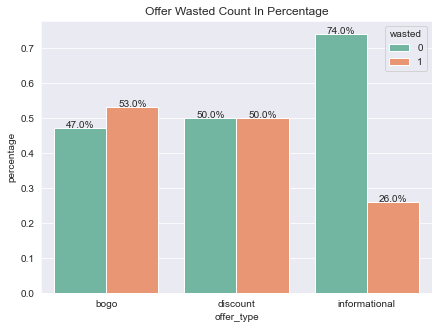

In [85]:
starbucks['interaction'] = 1
person_all_offers = starbucks.groupby(['person', 'offer_id','offer_type','event'])['interaction'].max().unstack(fill_value=0).reset_index()

#For Informational offers, if a person received but not viewed, then the offer is wasted
informational = person_all_offers[person_all_offers['offer_type']=='informational'].copy()
informational['wasted']=np.where(informational['offer viewed']==0,1,0)

# For BOGO and Discount offers, if a person (did not use an offer) or (used it without viewing), then the offer is wasted
bogo_discount = person_all_offers[person_all_offers['offer_type']!='informational'].copy()
bogo_discount['wasted']=np.where((bogo_discount["offer completed"]==1)&(bogo_discount["offer viewed"]==1),0,1)

plt.figure(figsize=[7,5])
sns.set_style("darkgrid")
offer_wasted = informational.append(bogo_discount)
offer_wasted_counts = (offer_wasted.groupby(['offer_type'])['wasted']
                      .value_counts(normalize=True).round(2)
                      .rename('percentage')
                      .reset_index())
ax = sns.barplot(data=offer_wasted_counts, x='offer_type', y='percentage', hue='wasted')
#vals = ax.get_yticks()
#ax.set_yticks(vals)
#ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Offer Wasted Count In Percentage')
for p in ax.patches:
    ax.annotate('{}%'.format(p.get_height()* 100, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   xytext=(0, 3),  # 3 points vertical offset
                   ha = 'center', va = 'center', 
                   textcoords = 'offset points');


An offer that is wasted may be caused by it being used without notice, or it was not redeemed, etc. BOGO offer is wasted most, which is more than 53%. Half of the discount offer is wasted. 26% informational offer is wasted.

### Q5. What kind of people are more likely to waste an offer? What offer characteristis will lead to wasted?

- People Side:
Categorize customer by demographic characteristics: data from 'profile' dataset, including age, gender, income, membership_in_years,etc. and transaction history: from 'transtript' dataset for customer past transction history, such as average spent, etc.

- Offer Side:
Offer information: from 'protfolio' dataset for offer information, such as offer type, difficulty, channels, reward, etc, and form Transaction history: mixed information  offer usage(has been wasted or not), etc. 

In [50]:
offer_wasted.head()

event,person,offer_id,offer_type,offer completed,offer received,offer viewed,wasted
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0
12,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0


In [51]:
# Get customer past transaction stats

trans_history = starbucks.groupby(['person'], as_index=False).agg({'spent':{'sum','mean'}, 'gained':'sum'}).round(2)
trans_history.columns=['person', 'spent_total','spent_avg','gained_total']
trans_history.head()                      

,person,spent_total,spent_avg,gained_total
0,0009655768c64bdeb2e877511632db8f,6.38,127.60,9.0
1,00116118485d4dfda04fdbaba9a87b5c,0.58,4.09,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,4.41,79.46,13.0
3,0020c2b971eb4e9188eac86d93036a77,10.36,196.86,14.0
4,0020ccbbb6d84e358d3414a3ff76cffd,6.70,154.05,13.0


#### Data Processing to get the clean dataset for modeling

In [100]:
# merge dataframes together
model_df = pd.merge(trans_history, profile, how='left', on=['person'], suffixes=('', '_y'))
model_df = pd.merge(offer_wasted, model_df, how='left', on=['person'], suffixes=('', '_y'))
model_df = pd.merge(model_df, portfolio, how='left', on=['offer_id'], suffixes=('', '_y'))

# Drop duplicatd columns in merge
model_df.drop(model_df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

# Drop columns don't need
model_df.drop(['member_since'], axis=1, inplace=True)

# Drop records that has missing value in demographic characteristics
model_df.dropna(how='any', inplace=True)

# Reorder columns
cols = ['wasted', 'person', 'offer_id', 'offer_type', 'offer completed', 'offer received',
       'offer viewed', 'spent_total', 'spent_avg', 'gained_total','reward',
       'channels', 'difficulty', 'duration', 'gender', 'age', 'became_member_on', 'income', 'age_group',
       'income_group', 'membership_in_years']
model_df = model_df[cols]

#label encoding 
model_df = model_df.join(model_df.channels.str.join('|').str.get_dummies())  # split channels column
model_df = model_df.join(pd.get_dummies(model_df[['gender']]))

# rename columns
model_df = model_df.rename(columns={'offer completed':'offer_completed', 
                                    'offer received':'offer_received',
                                    'offer viewed':'offer_viewed'})

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   wasted               55222 non-null  int64         
 1   person               55222 non-null  object        
 2   offer_id             55222 non-null  object        
 3   offer_type           55222 non-null  object        
 4   offer_completed      55222 non-null  int64         
 5   offer_received       55222 non-null  int64         
 6   offer_viewed         55222 non-null  int64         
 7   spent_total          55222 non-null  float64       
 8   spent_avg            55222 non-null  float64       
 9   gained_total         55222 non-null  float64       
 10  reward               55222 non-null  int64         
 11  channels             55222 non-null  object        
 12  difficulty           55222 non-null  int64         
 13  duration             55222 non-

#### Feature Selection -- Correlation Matrix Heatmap

Correlation states how the features are related to each other or the target variable. Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

The first vertical row indicates the each variable's correlation to the target variable 'wasted'.

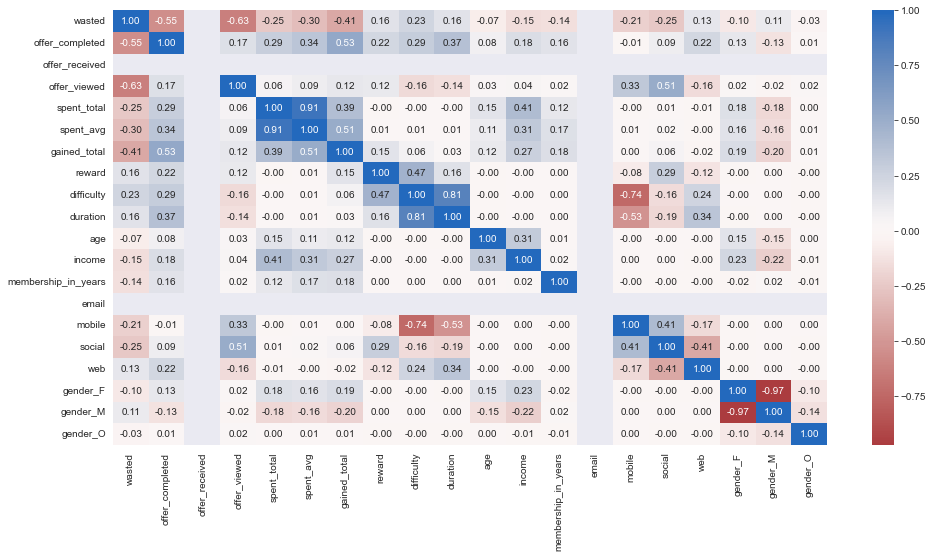

In [101]:
plt.figure(figsize=[16,8])
sns.heatmap(model_df.corr(), annot=True, fmt='.2f', cmap='vlag_r', center=0);

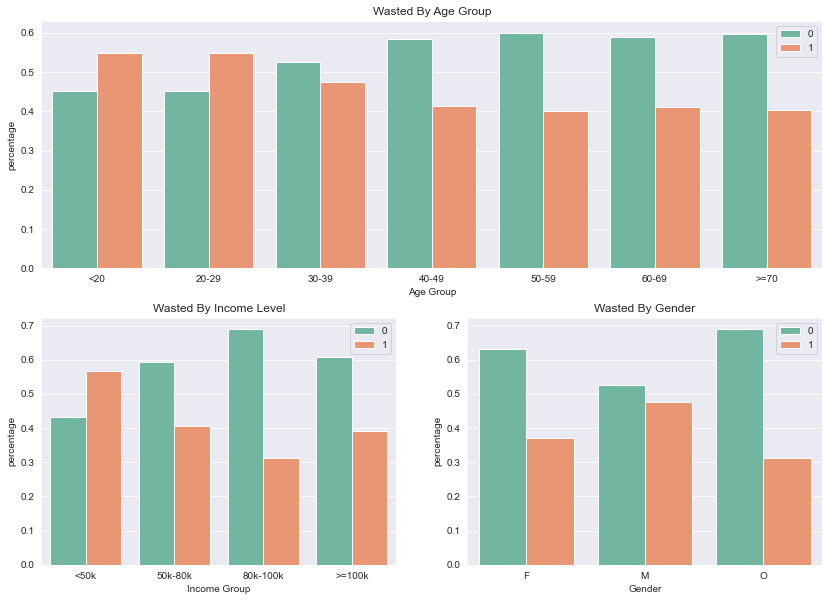

In [102]:
# Explore People Characteristics

plt.figure(figsize=[14, 10])

plt.subplot(2,1,1)
sns.barplot(data=model_df.groupby(['age_group'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='age_group', y='percentage', hue='wasted', order=age_order)
plt.legend(loc='upper right')
plt.title('Wasted By Age Group')
plt.xlabel('Age Group');

plt.subplot(2,2,3)
sns.barplot(data=model_df.groupby(['income_group'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='income_group', y='percentage', hue='wasted', order=income_order)
plt.legend(loc='upper right')
plt.title('Wasted By Income Level')
plt.xlabel('Income Group');

plt.subplot(2,2,4)
sns.barplot(data=model_df.groupby(['gender'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='gender', y='percentage', hue='wasted', order=gender_order)
plt.legend(loc='upper right')
plt.title('Wasted By Gender')
plt.xlabel('Gender');

- Customers younger than 30 years old are much more likely to waste an offer, because more than half of the offers didn't be used. 
- Customers with lower income than 50k are much more likely to waste an offer. On the other hand, Starbucks offers re most effective to customer who's income leve is between 80k to 100k.
- Male cusotmers are more likely to waste an offer.

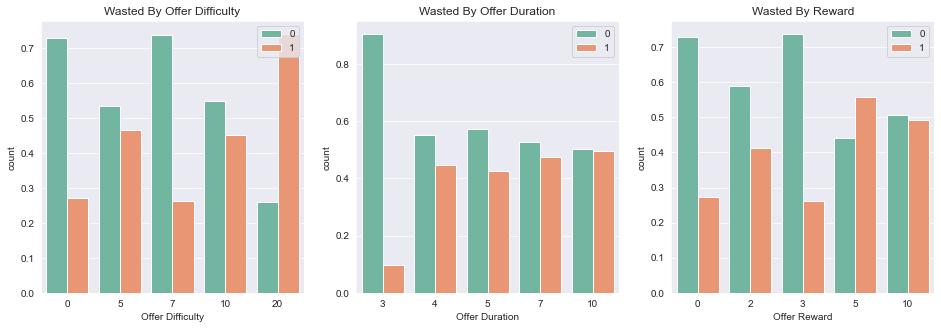

In [103]:
# Explore offer characteristics
plt.figure(figsize=[16, 5])

plt.subplot(1,3,1)
sns.barplot(data=model_df.groupby(['difficulty'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='difficulty', y='percentage', hue='wasted')
plt.legend(loc='upper right')
plt.title('Wasted By Offer Difficulty')
plt.ylabel('count')
plt.xlabel('Offer Difficulty');

plt.subplot(1,3,2)
sns.barplot(data=model_df.groupby(['duration'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='duration', y='percentage', hue='wasted')
plt.legend(loc='upper right')
plt.title('Wasted By Offer Duration')
plt.ylabel('count')
plt.xlabel('Offer Duration');

plt.subplot(1,3,3)
sns.barplot(data=model_df.groupby(['reward'])['wasted']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .reset_index(), x='reward', y='percentage', hue='wasted')
plt.legend(loc='upper right')
plt.title('Wasted By Reward')
plt.ylabel('count')
plt.xlabel('Offer Reward');

- Offer with 0 difficulty, 0 reward and 3-day duration is informational offer, which has relatively lower wasted rate.
- Offer with the difficulty of `$7` to be qualified for reward is surprisingly least likely to be wasted, which is the middle level of difficulty. Offer requires more than `$10` to qualify for reward has much higher wasted rate.
- Offer duration time has a slight influence on whether an offer will be wasted or not. A 5-day duration is slightly more efficient for a offer valid time.
- Offer with `$3` as reward is least like to be wasted, while an offer with `$5` reward is most likely to be wasted.

In [104]:
# drop categorical columns that have dummy varaibles created 

model_df = model_df.drop(['person','offer_type', 'offer_id','channels','reward','became_member_on', 'gender',
                         'age_group', 'income_group', 'offer_received', 'offer_viewed', 'offer_completed'], axis=1)

# drop columns with only one value
model_df = model_df.drop(['email'], axis=1)

In [105]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wasted               55222 non-null  int64  
 1   spent_total          55222 non-null  float64
 2   spent_avg            55222 non-null  float64
 3   gained_total         55222 non-null  float64
 4   difficulty           55222 non-null  int64  
 5   duration             55222 non-null  int64  
 6   age                  55222 non-null  float64
 7   income               55222 non-null  float64
 8   membership_in_years  55222 non-null  float64
 9   mobile               55222 non-null  int64  
 10  social               55222 non-null  int64  
 11  web                  55222 non-null  int64  
 12  gender_F             55222 non-null  uint8  
 13  gender_M             55222 non-null  uint8  
 14  gender_O             55222 non-null  uint8  
dtypes: float64(6), int64(6), uint8(3)
me

In [106]:
model_df.head()

,wasted,spent_total,spent_avg,gained_total,difficulty,duration,age,income,membership_in_years,mobile,social,web,gender_F,gender_M,gender_O
0,0,6.38,127.60,9.0,0,4,33.0,72000.0,4.6,1,0,1,0,1,0
1,0,6.38,127.60,9.0,0,3,33.0,72000.0,4.6,1,1,0,0,1,0
2,0,4.41,79.46,13.0,0,4,40.0,57000.0,3.9,1,0,1,0,0,1
3,0,4.41,79.46,13.0,0,3,40.0,57000.0,3.9,1,1,0,0,0,1
4,0,10.36,196.86,14.0,0,3,59.0,90000.0,5.8,1,1,0,1,0,0


In [114]:
model_df.columns

Index(['wasted', 'spent_total', 'spent_avg', 'gained_total', 'difficulty',
       'duration', 'age', 'income', 'membership_in_years', 'mobile', 'social',
       'web', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

# Modeling

### Q6 Build a prediction engine to determine if customer will waste an offer or not? 

The goal is to predict whether customer will waste an offer or not. The output should be discrete variables(0 - unwasted or 1 - wasted).  Therefore, we choose classification models. Here, we will run three different supervided models and pick the most optimize one.

### Three ML algorithms:
1. Decision Trees
2. Random Forest
3. K Nearest Neighbors(KNN)

Since we use classification models, there are some metrics provided by sklearn libary to eveluate classification model performance: 

### Metrics:
1. **Confusion Matrix(not a metric but a tool)**: a tabular visualization of the model predictions versus the ground-truth labels. Each row of confusion matrix represents the instances in a predicted class and each column represents the instances in an actual class. As we can see diagonal elements of this matrix denote the correct prediction for different classes, while the off-diagonal elements denote the samples which are mis-classified.
2. **Accuracy Score**: the percent of correct predictions, which equals the number of correct predictions divided by the total number of predictions 
3. **Precision**: the number of correctly identified members among the class. There are many cases in which classification accuracy is not a good indicator of the model performance. One of these scenarios is when the class distribution is imbalanced (one class is more frequent than others). In this case, even if we predict all samples as the most frequent class we would get a high accuracy rate, which does not make sense at all (because the model is not learning anything, and is just predicting everything as the top class).
4. **Recall**: the fraction of samples from a class which are correctly predicted by the model over the whole number of element of this class. Recall reflects a classifier’s performance with respect to false negatives (how many did we miss), while precision gives us information about its performance with respect to false positives(how many did we catch).
5. **F1 Score**: combines precision and recall to give higher priority in evaluation. It is the harmonic mean of Precision and Recall. F1 = 2 * (precision * recall) / (precision + recall)

In [107]:
def data_classification_modeling(model, clean_df, target_var='wasted'):
    '''
    INPUT:
    model - a ML algorithm
    clean_df - a clean dataframe generated from data_processing
    target_var - the prediction target variable
    
    OUTPUT:
    result_df - a dataframe contains the scores associatd with training and testing data set
    '''
    # Split dataset for training and testing

    X = clean_df.drop(target_var, axis=1)
    y = clean_df[target_var]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    print('Training data Shape X: {}, y: {}'.format(X_train.shape, y_train.shape))
    print('Testing data Shape X: {}, y: {}'.format(X_test.shape, y_test.shape) )
    
    # Run prediction model
    results = {}
    
    # Fit the model to the training data:
    model = model.fit(X_train, y_train)
    
    # predict on the tarining, testing data:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Confusion matrix:
    conf_matrix = confusion_matrix(y_pred_test, y_test)
    
    # Accuracy for testing data:
    #results['test accuracy'] = accuracy_score(y_pred_test, y_test)
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
    
    # add accuracy
    results['accuracy'] = accuracy_score(y_test, y_pred_test)
    
    # Scores on testing data:
    results['f1_score'] = fbeta_score(y_test, y_pred_test, beta = 0.5)
    results['precision'] = precision_score(y_test, y_pred_test)    
    results['recall'] = recall_score(y_test, y_pred_test)
    
    # ROC Score
    #results['roc'] = roc_auc_score(y_test, y_pred_test).str
    
    # Print metrics, scores
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    print(classification_report(y_test, y_pred_test,digits=2))
    print("Training accuracy:%.2f" % results['training_score'])
    print("Test accuracy:%.2f" % results['testing_score'])
    print('The accuracy:%.2f' % results['accuracy'])
    
    #return results

Deecisin Tree Prediction Score:
Training data Shape X: (41416, 14), y: (41416,)
Testing data Shape X: (13806, 14), y: (13806,)
DecisionTreeClassifier trained on 41416 samples.
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      7984
           1       0.72      0.74      0.73      5822

    accuracy                           0.77     13806
   macro avg       0.76      0.77      0.76     13806
weighted avg       0.77      0.77      0.77     13806

Training accuracy:1.00
Test accuracy:0.77
The accuracy:0.77


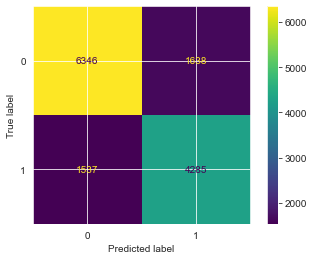

In [108]:
# Decision Tree

decision_tree = DecisionTreeClassifier(random_state = 42)
print('Deecisin Tree Prediction Score:')
data_classification_modeling(decision_tree, model_df, 'wasted')

Training data Shape X: (41416, 14), y: (41416,)
Testing data Shape X: (13806, 14), y: (13806,)
RandomForestClassifier trained on 41416 samples.
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      7984
           1       0.77      0.65      0.71      5822

    accuracy                           0.77     13806
   macro avg       0.77      0.75      0.76     13806
weighted avg       0.77      0.77      0.77     13806

Training accuracy:0.77
Test accuracy:0.77
The accuracy:0.77
Random Forest Prediction Score:


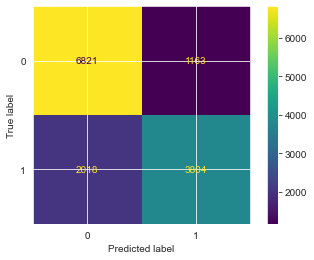

In [116]:
#Ranmdom Forest

random_forest = RandomForestClassifier(random_state = 42, max_depth=3)
rf_score = data_classification_modeling(random_forest, model_df, 'wasted')
print('Random Forest Prediction Score:')
rf_score

Training data Shape X: (41416, 14), y: (41416,)
Testing data Shape X: (13806, 14), y: (13806,)
KNeighborsClassifier trained on 41416 samples.
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      7984
           1       0.73      0.54      0.62      5822

    accuracy                           0.72     13806
   macro avg       0.72      0.70      0.70     13806
weighted avg       0.72      0.72      0.71     13806

Training accuracy:0.76
Test accuracy:0.72
The accuracy:0.72
KNN Prediction Score:


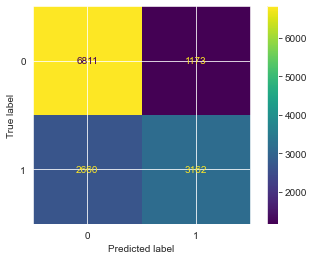

In [110]:
# K Nearest Neighbors 

kneighbors = KNeighborsClassifier(n_neighbors=10, leaf_size=30)
knn_score = data_classification_modeling(kneighbors, model_df, 'wasted')
print('KNN Prediction Score:')
knn_score

# Eveluation & Refinement

## Models Eveluation

From the above models' performance results, Random Forest is the winner with the leading performance overall in this case.

Both Decision Tree and Random Forest have higher performance, around 77% accuracy than the 72% accuracy of the KNN model. The **Decision Tree** model has 100% accuracy in training but drops to 77% in the testing dataset. This is most likely because of the overfitting on the training data. Compared to other machine learning models, overfitting in decision trees can easily happen as their learning algorithms can produce large and complex decision trees that perfectly fit training instances.

Why Random Forest outperforms the Decision Tree? - **Random Forest** is a collection of decision trees and the average/majority vote of the forest is selected as the predicted output. It does not rely on the feature importance given by a single decision tree. In other words, it is more robust and accurate than a Decision Tree.

As for **K-Nearest Neighbors** model in this scenario, not only the accuracy is not as good as Random Forest, but another drawback of the KNN model is the cost of time. Basically, KNN is to explore your neighborhood, assume the test datapoint to be similar to them, and derive the output. A majority voting is applied over the k nearest data points and come up with the prediction, which will need much more runtime in large size of sample data.

Therefore, we choose the **Random Forest** algorithm to proceed with optimization further.

## Refinement -- Hyperparameter Tuning

### Grid Search Cross Validation
Grid Search Cross Validation exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter and evaluates all combinations we defined.

We will try adjusting the following set of hyperparameters:
- n_estimators = number of trees in the foreset
- max_depth = max number of levels in each decision tree


### K-Fold Cross Validation
As of now we have divided the input data into two part and run training and testing respectively with the classification model. This method could be not reliable as the training and testing data not always have same kind of variation as the original data, which will affect the accuracy of the model. **Cross Validation** solves this problem by shulffing the dataset in order to remove any kind of order and dividing the input data into multiple groups instead of only two groups.

**K-Fold Cross Validation** is one of the common cross validation method. Here we devide the data into K=5 folds. We will have 5 sets of data to train and test our model. In other words, the model will get trained and tested for 5 times, and for each time we will use one fold as test data and rest all as training data. What makes it great is for every iteration, the data in training and test fold changes which adds to the effectiveness of this method.

In [111]:
# Input variables and target variable
X = model_df.drop('wasted', axis=1)
y = model_df['wasted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model to the training data:
# rf = rf.fit(X_train, y_train)
    
# # Predict on the tarining, testing data:
# y_pred_train = rf.predict(X_train)
# y_pred_test = rf.predict(X_test)

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'weighted'),
           'recall': make_scorer(recall_score, average = 'weighted')}

# Optimize by hyperparameter tuning
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
}

# Grid Search
grid_no_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='accuracy').fit(X_train, y_train)
y_pred_test = grid_no_up.predict(X_test)
print(grid_no_up.best_estimator_)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)


Random Forest K-Fold Cross Validation Scores:


,fit_time,score_time,test_accuracy,test_precision,test_recall
0,3.659419,0.190626,0.834138,0.834752,0.834138
1,3.679024,0.195330,0.826150,0.826643,0.826150
2,3.714176,0.196403,0.832428,0.833021,0.832428
3,3.771562,0.193209,0.826029,0.827631,0.826029
4,3.741098,0.197294,0.825788,0.827579,0.825788


Average Score of K Fold Scores: 
test_accuracy     0.83
test_precision    0.83
test_recall       0.83
dtype: float64


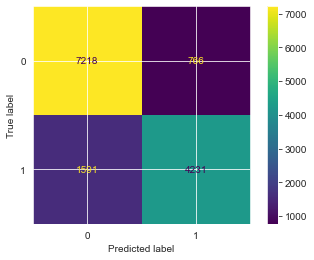

In [117]:
# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train model with best parameters
rf_opt = RandomForestClassifier(max_depth=15, random_state=42, n_estimators=200)

# Cross validation with k-fold
cv_opt = cross_validate(rf_opt, X_train, y_train, cv=kf, scoring=scoring)
cv_opt_df = pd.DataFrame.from_dict(cv)

# Confusion matrix:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

print('Random Forest K-Fold Cross Validation Scores:')
display(cv_opt_df)

print('Average Score of K Fold Scores: \n{}'.format(cv_opt_df.mean()[2:].round(2)))

### Modeling Conclusion

Through the Hyperparameter Tunning with Grid Search with Cross Validation, we found the best parameters for our Random Forest model are `RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)`. 

With the best parameters, we then applied K-Fold Cross validation to train the model. K-Fold Cross Validation significantly reduces underfitting as we are using most of the data for training(fitting), and also significantly reduces overfitting as most of the data is also being used in validation set. 

As a result, the accuracy has an obvious improvement from 77% to 83%.

# Conclusion

- There are 167184 offers sent to customer, around 43% is BOGO type, 42% is Discount type and 16% is Informational type. On average, customer received more than 4 BOGO and Discount offers and around 2.5 Informational offer.

- Overall, BOGO offer has worse performance than Discount offer and Informational offer.BOGO is more likely to be wasted.

- Customers younger than 30 years old are much more likely to waste an offer, because more than half of the offers didn't be used. Customers with lower income than 50k are much more likely to waste an offer. On the other hand, Starbucks offers re most effective to customers whose income level is between 80k to 100k. Male customers are more likely to waste an offer.

- Offer with 0 difficulty, 0 reward and 3-day duration is informational offer, which has a relatively lower wasted rate. Offer with the difficulty of `$7` to be qualified for reward is surprisingly least likely to be wasted, which is the middle level of difficulty. Offer requires more than `$10` to qualify for reward has a much higher wasted rate. Offer duration time has slight influence on whether an offer will be wasted or not. A 5-day duration is slightly more efficient for an offer valid time. An offer with `$3` as a reward is least like to be wasted, while an offer with `$5` reward is most likely to be wasted.

- A Random Forest classification model with K=5 fold Cross Validation method is able to predict whether an offer will be wasted or not with an accuracy of 83%.

# Future Improvement

- Find a better approach to measure the effectiveness of informational offer. It will be great if we can find other information/data to know if a tranction is encouraged by the informtional offer. 
- Fill missing value in gender/income/age instead of dropping the rows with those values missing
- Go deeper into the modeling part, such as trying additional models(XGBoost, SVM, etc). If possible, find the better resource(Virtual Machine) to run refinement, apply hyperparameter pruning with Grid Search Cross Validation to find the most optimized model. Learn more about Machine Learning algorithms to consolidate the conclusion.